# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
#from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
#from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy

from helpers.normalization import normalize, denormalize, renormalize
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.


In [2]:
#import importlib
#importlib.reload(helpers.normalization)

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['font.size'] = 20

# Analysis

In [3]:
file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12_params.pkl
with parameters: dict_keys(['excluded_shots', 'model_type', 'epochs', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'actuator_names', 'scalar_input_names', 'batch_size', 'process_data', 'predict_deltas', 'lookahead', 'profile_downsample', 'std_activation', 'sample_weighting', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_

In [4]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [5]:
#import importlib
#importlib.reload(helpers.data_generator)
traindata, valdata, normalization_dict = helpers.data_generator.process_data(scenario['raw_data_path'], #'/scratch/gpfs/jabbate/mixed_data/final_data.pkl',
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2,
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'], #pruning_functions, 
                                                      #excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False) #scenario['shuffle_generators'])

Loading
Signals: bt, curr_target, dens, density_estimate, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  7234
Number of shots used:  7234
Total number of timesteps:  769681
Shots with Complete NaN: 
525109 samples total
Removing ECH
Removed 230171 samples
294938 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 52273 samples
242665 samples remaining
Removing weird I-coils
Removed 55436 samples
187229 samples remaining
Removing NaN
Removed 0 samples
187229 samples remaining
Removing dudtrip
Removed 9571 samples
177658 samples remaining
177658 samples remaining after pruning
Total number of samples:  177658
Number of training samples:  177658
Number of validation samples:  0


In [38]:
#import importlib
#importlib.reload(helpers.data_generator)
traindata, valdata, normalization_dict = helpers.data_generator.process_data('/scratch/gpfs/jabbate/new_data_EFIT02/final_data_batch_78.pkl', #'/scratch/gpfs/jabbate/mixed_data/final_data.pkl',
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2,
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=['remove_nan','remove_dudtrip','remove_non_gas_feedback'],#scenario['pruning_functions'], #pruning_functions, 
                                                      #excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False) #scenario['shuffle_generators'])

Loading
Signals: bt, curr_target, dens, density_estimate, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  43
Number of shots used:  43
Total number of timesteps:  3832
Shots with Complete NaN: 
2756 samples total
Removing timesteps WITHOUT gas feedback
Removed 351 samples
2405 samples remaining
Removing NaN
Removed 0 samples
2405 samples remaining
Removing dudtrip
Removed 1385 samples
1020 samples remaining
1020 samples remaining after pruning
Total number of samples:  1020
Number of training samples:  1020
Number of validation samples:  0


In [39]:
scenario['pruning_functions']

[<function helpers.pruning_functions.remove_nan(data, verbose)>,
 <function helpers.pruning_functions.remove_dudtrip(data, verbose)>,
 <function helpers.pruning_functions.remove_I_coil(data, verbose)>,
 <function helpers.pruning_functions.remove_non_gas_feedback(data, verbose)>,
 <function helpers.pruning_functions.remove_ECH(data, verbose)>]

In [40]:
163303 in np.unique(traindata['shotnum'])

False

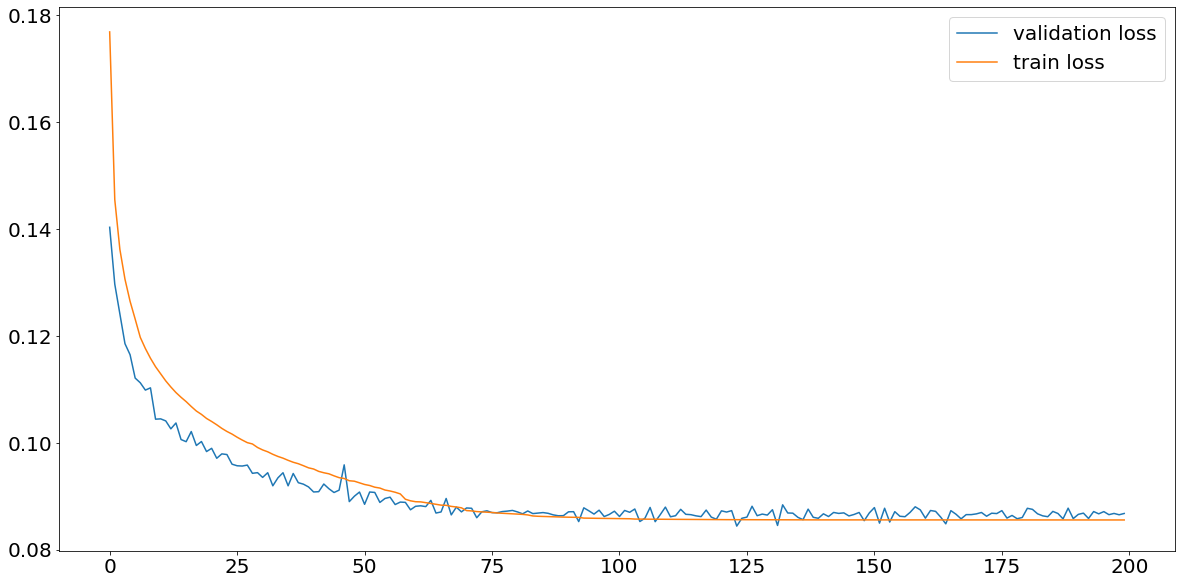

In [5]:
plt.plot(scenario['history']['val_loss'],label='validation loss')
plt.plot(scenario['history']['loss'],label='train loss')
plt.legend()
#plt.ylim(0,.1)
plt.show()

In [47]:
scenario['lookbacks']

{'dens': 0,
 'temp': 0,
 'q_EFIT01': 0,
 'rotation': 0,
 'press_EFIT01': 0,
 'curr_target': 6,
 'pinj': 6,
 'tinj': 6,
 'target_density': 6,
 'bt': 6,
 'density_estimate': 6,
 'li_EFIT01': 6,
 'volume_EFIT01': 6,
 'triangularity_top_EFIT01': 6,
 'triangularity_bot_EFIT01': 6,
 'C_coil_method': 6,
 'I_coil_method': 6,
 'curr': 6,
 'dud_trip': 6,
 'ech': 6,
 'gas_feedback': 6,
 'shotnum': 6,
 'time': 6}

In [14]:
denormed_traindata=helpers.normalization.denormalize(traindata.copy(),normalization_dict)

Denormalizing: 100%|##########| 23/23 [00:00<00:00, 32.78it/s]


In [7]:
def normalize(arr,signal):
    if scenario['predict_deltas']:
        return arr*normalization_dict[signal]['iqr']
    else:
        return helpers.normalization.denormalize_arr(arr,normalization_dict[signal])

In [15]:
sig_names={'curr_target': 'ip target (A)',
           'curr': 'ip (A)',
           'rotation': 'rotation (kHz)',
           'bt': 'Bt (T)',
       'temp':'Te (keV)', 
       'dens': 'ne (10^19 m^-3)',
       'q_EFIT01':'q EFIT01',
       'pinj': 'pinj (kW)', 
       'gasA': 'gasA (V)',
       'tinj':'tinj (Nm)',
       'target_density': 'target <ne> (10^19 m^-3)',
          'press_EFIT01': 'Pressure EFIT01 (N/m^2)'}
sig_lims={'rotation': [0,200],
          'bt': [-10,10],
          'thomson_temp_EFITRT1': [0,2e3],             
          'curr': [0,3e6],
          'curr_target': [0,3e6],
          'temp':[0,10], 
          'dens': [0,10],
          'pinj': [0,1.5e4],
          'tinj':[0,10],
          'target_density': [0,8],
          'gasA': [0,10]}

In [16]:
psi = np.linspace(0,1,scenario['profile_length'])

# Make full-shot pictures / video #

In [24]:
legend_size=5

def plot_prediction_for_shot_at_time(shotnum,t,filename=None,denormalized=False,
                                    changed_input_keys=[]):

    if denormalized:
        proper_traindata=denormed_traindata
    else:
        proper_traindata=traindata
    
    sigs=scenario['actuator_names']
    profiles=scenario['target_profile_names']
    input_profiles=scenario['input_profile_names']
    changed_profile_keys=[] #'thomson_dens_EFITRT1']
    
    shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]

    time_offset=np.argmin(abs(traindata['time'][shot_indices,-scenario['lookahead']-1]-t))

    #prev_targets=train_generator[shot_indices[0]+time_offset-1][1]

    inputs=train_generator[shot_indices[0]+time_offset][0]
    targets=train_generator[shot_indices[0]+time_offset][1]
    
    changed_input=copy.deepcopy(inputs)
    for key in changed_input_keys:
        #changed_input['input_past_{}'.format(key)]=np.array([np.linspace(-2,0,actuator_lookback)])
        #changed_input['input_past_{}'.format(key)]=np.zeros(changed_input['input_past_{}'.format(key)].shape)

        # the value at the end of the lookahead
        #prev=traindata[key][shot_indices[0]+time_offset][-1]
        
        # the value at the current timestep
        prev=traindata[key][shot_indices[0]+time_offset][-scenario['lookahead']-1]
        
        # to float the current timestep into the future
        # changed_input['input_future_{}'.format(key)]=np.array([[prev]*scenario['lookahead']])
        
        # to ramp up from the previous timestep
        #changed_input['input_future_{}'.format(key)]=np.array([np.linspace(prev,prev+1,scenario['lookahead'])])
        
        # if you want to add a constant to the true values
        #changed_input['input_future_{}'.format(key)]+=2
        #changed_input['input_past_{}'.format(key)]+=2
        
        # if you want 0s through the future
        #changed_input['input_future_{}'.format(key)]=np.zeros(changed_input['input_future_{}'.format(key)].shape)
        
        # if you want the previoius to be floated
        #changed_input['input_past_{}'.format(key)]=np.array([[prev]*(scenario['actuator_lookback']+1)])
        
        # if you want to have the whole thing flat 
        changed_input['input_future_{}'.format(key)]=np.array([[prev]*scenario['lookahead']])

    for key in changed_profile_keys:
        #changed_input['input_{}'.format(key)]=np.array([[[0]*scenario['profile_length']]])
        changed_input['input_{}'.format(key)]-=np.array([[.5*np.linspace(1,1,scenario['profile_length'])]])
        #changed_input['input_{}'.format(key)]+=np.array([targets['target_{}'.format(key)]])
    
    num_cols=2

    fig=plt.figure()
    for i,sig in enumerate(sigs):
        ax=fig.add_subplot(len(sigs),num_cols,i*num_cols+1)
        if len(traindata[sig][shot_indices].shape)>2:
            ax.plot(traindata['time'][shot_indices,-scenario['lookahead']-1],
                    np.mean(proper_traindata[sig][shot_indices,-scenario['lookahead']-1,:],axis=1),
                    c='b')
    #         ax.contourf(traindata['time'][shot_indices,-lookahead],
    #                 psi,
    #                 traindata[sig][shot_indices,-lookahead,::scenario['profile_downsample']].T)
            if denormalized:
                ax.set_ylim(sig_lims[sig])
            else:
                ax.set_ylim(-2,2)

        else:
#             ax.plot(traindata['time'][shot_indices[0],:-scenario['lookahead']-1],
#                             traindata[sig][shot_indices[0],:-scenario['lookahead']-1],
#                    c='b')
            #median=scenario['normalization_dict'][sig]['median']
            #iqr=scenario['normalization_dict'][sig]['iqr']
            ax.plot(traindata['time'][shot_indices,-scenario['lookahead']-1],
                    proper_traindata[sig][shot_indices,-scenario['lookahead']-1],
                    c='b',
                    label='True')
            if sig in changed_input_keys:
                changed_input_final=np.append(changed_input['input_past_{}'.format(sig)].squeeze(),changed_input['input_future_{}'.format(sig)].squeeze())
                if denormalized:
                    changed_input_final=helpers.normalization.denormalize_arr(changed_input_final,normalization_dict[sig])
                ax.plot(traindata['time'][shot_indices[0]+time_offset,:],
                        changed_input_final,
                        color='r',
                        label='Perturbation')
                ax.legend(prop={'size': legend_size})
            if denormalized:
                ax.set_ylim(sig_lims[sig])
            else:
                ax.set_ylim(-3,3)


        ax.axvline(traindata['time'][shot_indices[0]+time_offset,-scenario['lookahead']-1],
                  color='r')
        ax.axvline(traindata['time'][shot_indices[0]+time_offset,-1],
                  color='g')
        ax.axvline(traindata['time'][shot_indices[0]+time_offset,0],
                  color='k')
        ax.set_xlim(0,np.amax(traindata['time'][shot_indices]))
        if sig in profiles:
            if sig in sig_names:
                ax.set_title('Average {}'.format(sig_names[sig]))
            else:
                ax.set_title('Average {}'.format(sig))
        else: 
            if sig in sig_names:
                ax.set_title(sig_names[sig])
            else: 
                ax.set_title(sig)

    # truths=train_generator[shot_indices[0]+time_offset][1]

#     for i,profile in enumerate(input_profiles):
#         ax=fig.add_subplot(len(input_profiles),num_cols,i*num_cols+1+1)

#         ax.plot(psi,inputs['input_{}'.format(profile)].squeeze(),c='g')
#         if profile in changed_profile_keys:
#             ax.plot(psi,changed_input['input_{}'.format(profile)].squeeze(),c='r')
#         ax.set_title('{}'.format(profile))
#         ax.axhline(0,color='k',alpha=.5)
#         ax.set_ylim(-2,2)

    predictions=model.predict_on_batch(inputs)
    changed_predictions=model.predict_on_batch(changed_input)
    for i,profile in enumerate(profiles):
        ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1)
        ax.plot(psi,
                proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
                label='Previous',
                c='k')
        ax.plot(psi,
                proper_traindata[profile][shot_indices[0]+time_offset][-1][::scenario['profile_downsample']],
                label='Next',
                c='g')
        if scenario['predict_deltas']:
            full_profile_prediction=traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+predictions[i].squeeze()
            if denormalized: 
                full_profile_prediction=helpers.normalization.denormalize_arr(full_profile_prediction,normalization_dict[profile])
            ax.plot(psi,
                    full_profile_prediction,
                    label='Prediction',
                    c='b')
            full_profile_prediction_perturbed=traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+changed_predictions[i].squeeze()
            if denormalized:
                full_profile_prediction_perturbed=helpers.normalization.denormalize_arr(full_profile_prediction_perturbed,normalization_dict[profile])
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        full_profile_prediction_perturbed,
                        label='Perturbed Prediction',
                        c='r')
        else:
            ax.plot(psi,
                    predictions[i].squeeze(),
                    label='Prediction',
                    c='b')
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        changed_predictions[i].squeeze(),
                        label='Perturbed Prediction',
                        c='r')
        ax.legend(prop={'size': legend_size})
        if profile in sig_names:
            ax.set_title(sig_names[profile])
        else: 
            ax.set_title(profile)
        
        if denormalized:
            if profile in sig_lims:
                ax.set_ylim(sig_lims[profile])
        else:
            ax.set_ylim(-2,2)
        ax.axhline(0,color='k',alpha=.5)
        
#         ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1)

#         if scenario['predict_deltas']:
#             ax.plot(psi,targets['target_{}'.format(profile)].squeeze(),label='True',c='g')
#             ax.plot(psi,predictions[i].squeeze(),label='Prediction',
#                     c='b')
#             if len(changed_input_keys)+len(changed_profile_keys)>0:
#                 ax.plot(psi,changed_predictions[i].squeeze(),color='r',label='Perturbed Prediction')
#         else:
#             ax.plot(psi,
#                     targets['target_{}'.format(profile)].squeeze()-proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
#                     label='True',
#                     c='g')
#             ax.plot(psi,
#                     predictions[i].squeeze()-proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
#                     label='Prediction',
#                     c='b')
#             if len(changed_input_keys)+len(changed_profile_keys)>0:
#                 ax.plot(psi,
#                         changed_predictions[i].squeeze()-proper_traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']],
#                         color='r',
#                         label='Perturbed Prediction')
        
#         if profile in sig_names:
#             ax.set_title('Normalized {} change'.format(sig_names[profile]))
#         else:
#             ax.set_title('Normalized {} change'.format(profile))
#         ax.axhline(0,color='k',alpha=.5)
        
#         ax.set_ylim(-2,2)
#         ax.legend()

    time=train_generator.cur_times[:,max(scenario['profile_lookback'], scenario['actuator_lookback'])].squeeze()
    fig.suptitle('Shot {:.0f}, {:.0f} ms'.format(shotnum,time),fontsize=30)
    plt.subplots_adjust(hspace=.4)
    if filename is None:
        plt.show()
    else:
        print(filename)
        plt.savefig(filename)
        plt.close()

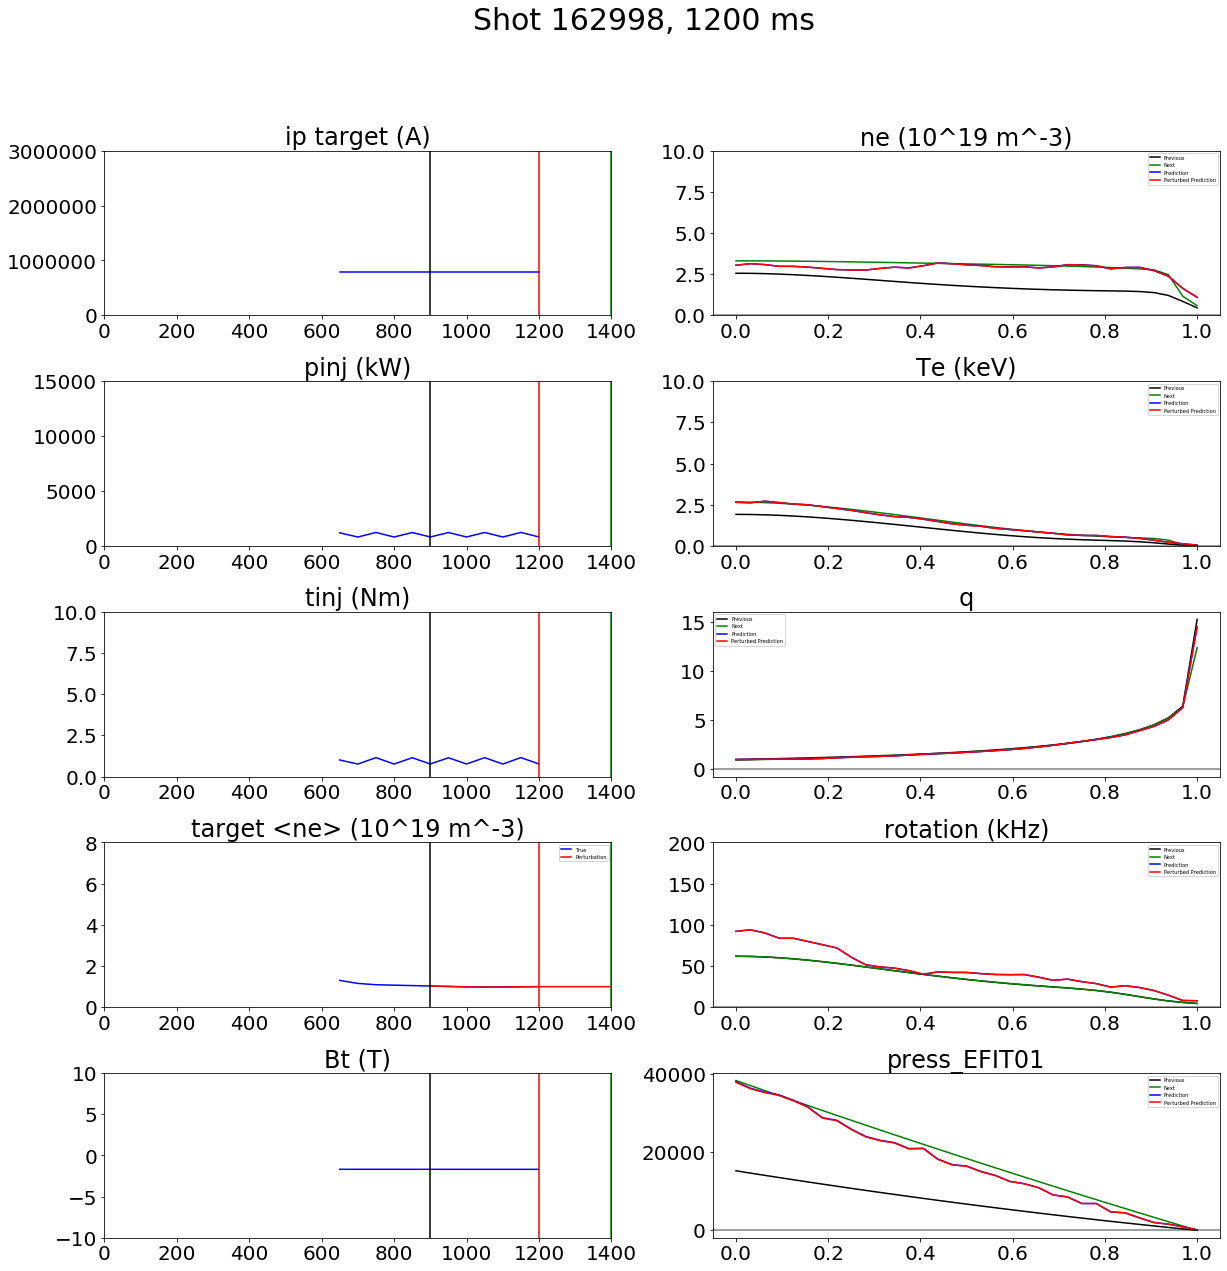

In [28]:
plt.rcParams["figure.figsize"] = (20,20)

all_shots=np.unique(traindata['shotnum'])
shotnum=np.random.choice(all_shots) #179118 160953 169478
t=np.random.choice([1500,2000,2500])
plot_prediction_for_shot_at_time(shotnum,t,denormalized=True,changed_input_keys=['target_density'])


In [71]:
basedir='/home/jabbate/pics_rotation'

shotnum=169478 #165093 #np.random.choice(all_shots)
shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]
time_offset=abs(traindata['time'][shot_indices,-scenario['lookahead']])
for i,t in enumerate(time_offset):
    plot_prediction_for_shot_at_time(shotnum,t,
                                     filename=os.path.join(basedir,'{}_{:02d}.png'.format(int(shotnum),i)),
                                     denormalized=True,
                                     changed_input_keys=['tinj'])

/home/jabbate/pics_rotation/169478_00.png
/home/jabbate/pics_rotation/169478_01.png
/home/jabbate/pics_rotation/169478_02.png
/home/jabbate/pics_rotation/169478_03.png
/home/jabbate/pics_rotation/169478_04.png
/home/jabbate/pics_rotation/169478_05.png
/home/jabbate/pics_rotation/169478_06.png
/home/jabbate/pics_rotation/169478_07.png
/home/jabbate/pics_rotation/169478_08.png
/home/jabbate/pics_rotation/169478_09.png
/home/jabbate/pics_rotation/169478_10.png
/home/jabbate/pics_rotation/169478_11.png
/home/jabbate/pics_rotation/169478_12.png
/home/jabbate/pics_rotation/169478_13.png
/home/jabbate/pics_rotation/169478_14.png
/home/jabbate/pics_rotation/169478_15.png
/home/jabbate/pics_rotation/169478_16.png
/home/jabbate/pics_rotation/169478_17.png
/home/jabbate/pics_rotation/169478_18.png
/home/jabbate/pics_rotation/169478_19.png
/home/jabbate/pics_rotation/169478_20.png
/home/jabbate/pics_rotation/169478_21.png
/home/jabbate/pics_rotation/169478_22.png
/home/jabbate/pics_rotation/169478

# 3-Example Profile Prediction Plot #

KeyError: 'q_EFIT01'

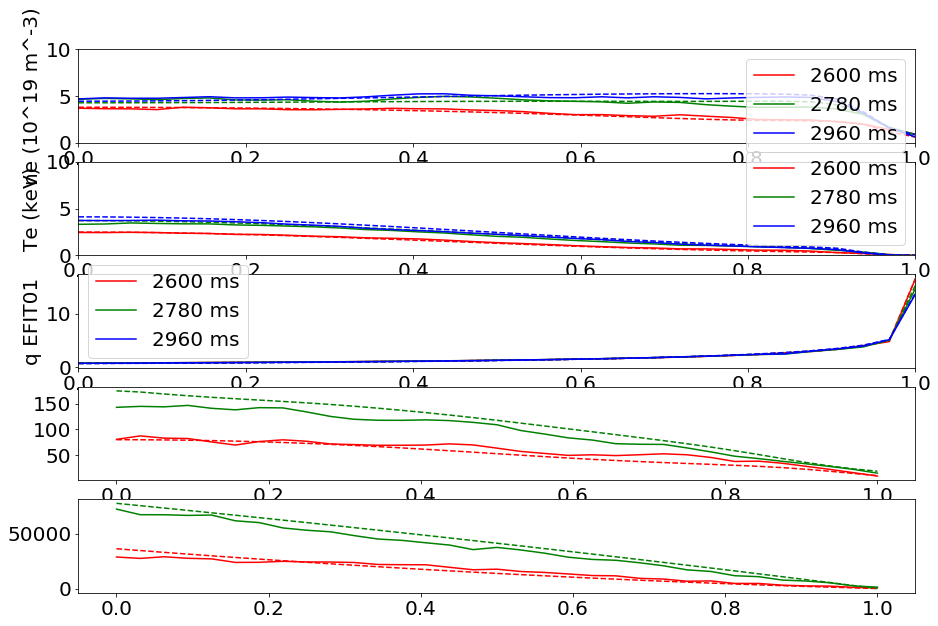

In [18]:
plt.rcParams["figure.figsize"] = (15,10)

denormalized=True
changed_input_keys=[]
shotnum=165093
times=[2600,2780,2960]
colors=['r','g','b']

psi = np.linspace(0,1,scenario['profile_length'])
sigs=scenario['actuator_names']
profiles=scenario['target_profile_names']
input_profiles=scenario['input_profile_names']
changed_profile_keys=[] #'thomson_dens_EFITRT1']

fig, axes = plt.subplots(len(profiles))

if denormalized:
    proper_traindata=denormed_traindata
else:
    proper_traindata=traindata

shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]

for j,t in enumerate(times):

    time_offset=np.argmin(abs(traindata['time'][shot_indices,-scenario['lookahead']-1]-t))

    #prev_targets=train_generator[shot_indices[0]+time_offset-1][1]

    inputs=train_generator[shot_indices[0]+time_offset][0]
    targets=train_generator[shot_indices[0]+time_offset][1]
    
    changed_input=copy.deepcopy(inputs)
    for key in changed_input_keys:
        #changed_input['input_past_{}'.format(key)]=np.array([np.linspace(-2,0,actuator_lookback)])
        #changed_input['input_past_{}'.format(key)]=np.zeros(changed_input['input_past_{}'.format(key)].shape)

        # the value at the end of the lookahead
        #prev=traindata[key][shot_indices[0]+time_offset][-1]
        
        # the value at the current timestep
        prev=traindata[key][shot_indices[0]+time_offset][-scenario['lookahead']-1]
        
        # to float the current timestep into the future
        # changed_input['input_future_{}'.format(key)]=np.array([[prev]*scenario['lookahead']])
        
        # to ramp up from the previous timestep
        #changed_input['input_future_{}'.format(key)]=np.array([np.linspace(prev,prev+1,scenario['lookahead'])])
        
        # if you want to add a constant to the true values
        #changed_input['input_future_{}'.format(key)]+=2
        #changed_input['input_past_{}'.format(key)]+=2
        
        # if you want 0s through the future
        #changed_input['input_future_{}'.format(key)]=np.zeros(changed_input['input_future_{}'.format(key)].shape)
        
        # if you want the previoius to be floated
        changed_input['input_past_{}'.format(key)]=np.array([[prev]*(scenario['actuator_lookback']+1)])
        
        # if you want to have the whole thing flat 
        changed_input['input_future_{}'.format(key)]=np.array([[prev]*scenario['lookahead']])

    for key in changed_profile_keys:
        #changed_input['input_{}'.format(key)]=np.array([[[0]*scenario['profile_length']]])
        changed_input['input_{}'.format(key)]-=np.array([[.5*np.linspace(1,1,scenario['profile_length'])]])
        #changed_input['input_{}'.format(key)]+=np.array([targets['target_{}'.format(key)]])

    predictions=model.predict_on_batch(inputs)
    changed_predictions=model.predict_on_batch(changed_input)
    for i,profile in enumerate(profiles):
        ax=axes[i]
        
        ax.plot(psi,
                proper_traindata[profile][shot_indices[0]+time_offset][-1][::scenario['profile_downsample']],
                c=colors[j],
               linestyle='--')
        if scenario['predict_deltas']:
            full_profile_prediction=traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+predictions[i].squeeze()
            if denormalized: 
                full_profile_prediction=helpers.normalization.denormalize_arr(full_profile_prediction,normalization_dict[profile])
            ax.plot(psi,
                    full_profile_prediction,
                    label='{} ms'.format(t),
                    c=colors[j])
            full_profile_prediction_perturbed=traindata[profile][shot_indices[0]+time_offset][0][::scenario['profile_downsample']]+changed_predictions[i].squeeze()
            if denormalized:
                full_profile_prediction_perturbed=helpers.normalization.denormalize_arr(full_profile_prediction_perturbed,normalization_dict[profile])
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        full_profile_prediction_perturbed,
                        label='Perturbed Prediction',
                        c='r')
        else:
            ax.plot(psi,
                    predictions[i].squeeze(),
                    label='{} ms'.format(t),
                    c=colors[j])
            if len(changed_input_keys)+len(changed_profile_keys)>0:
                ax.plot(psi,
                        changed_predictions[i].squeeze(),
                        label='Perturbed Prediction',
                        c='r')
                
        if j==len(times)-1:
            ax.legend()
            if profile in sig_names:
                ax.set_ylabel(sig_names[profile])
            else: 
                ax.set_ylabel(profile)
            ax.set_xlim((0,1))
            ax.set_xlabel('Normalized position')
            if denormalized:
                ax.set_ylim(sig_lims[profile])
            else:
                ax.set_ylim(-2,2)

fig.suptitle('DIII-D Shot {:.0f}'.format(shotnum),fontsize=30)
plt.subplots_adjust(hspace=.4)
plt.show()

# Average change due to perturbation #

4998.984296321869
curr_target average magnitude change: 110410.9360568996
pinj average magnitude change: 497.4022382181705
tinj average magnitude change: 0.3511369786762271
target_density average magnitude change: 0.3241594627847167
bt average magnitude change: 0.19245705658501883


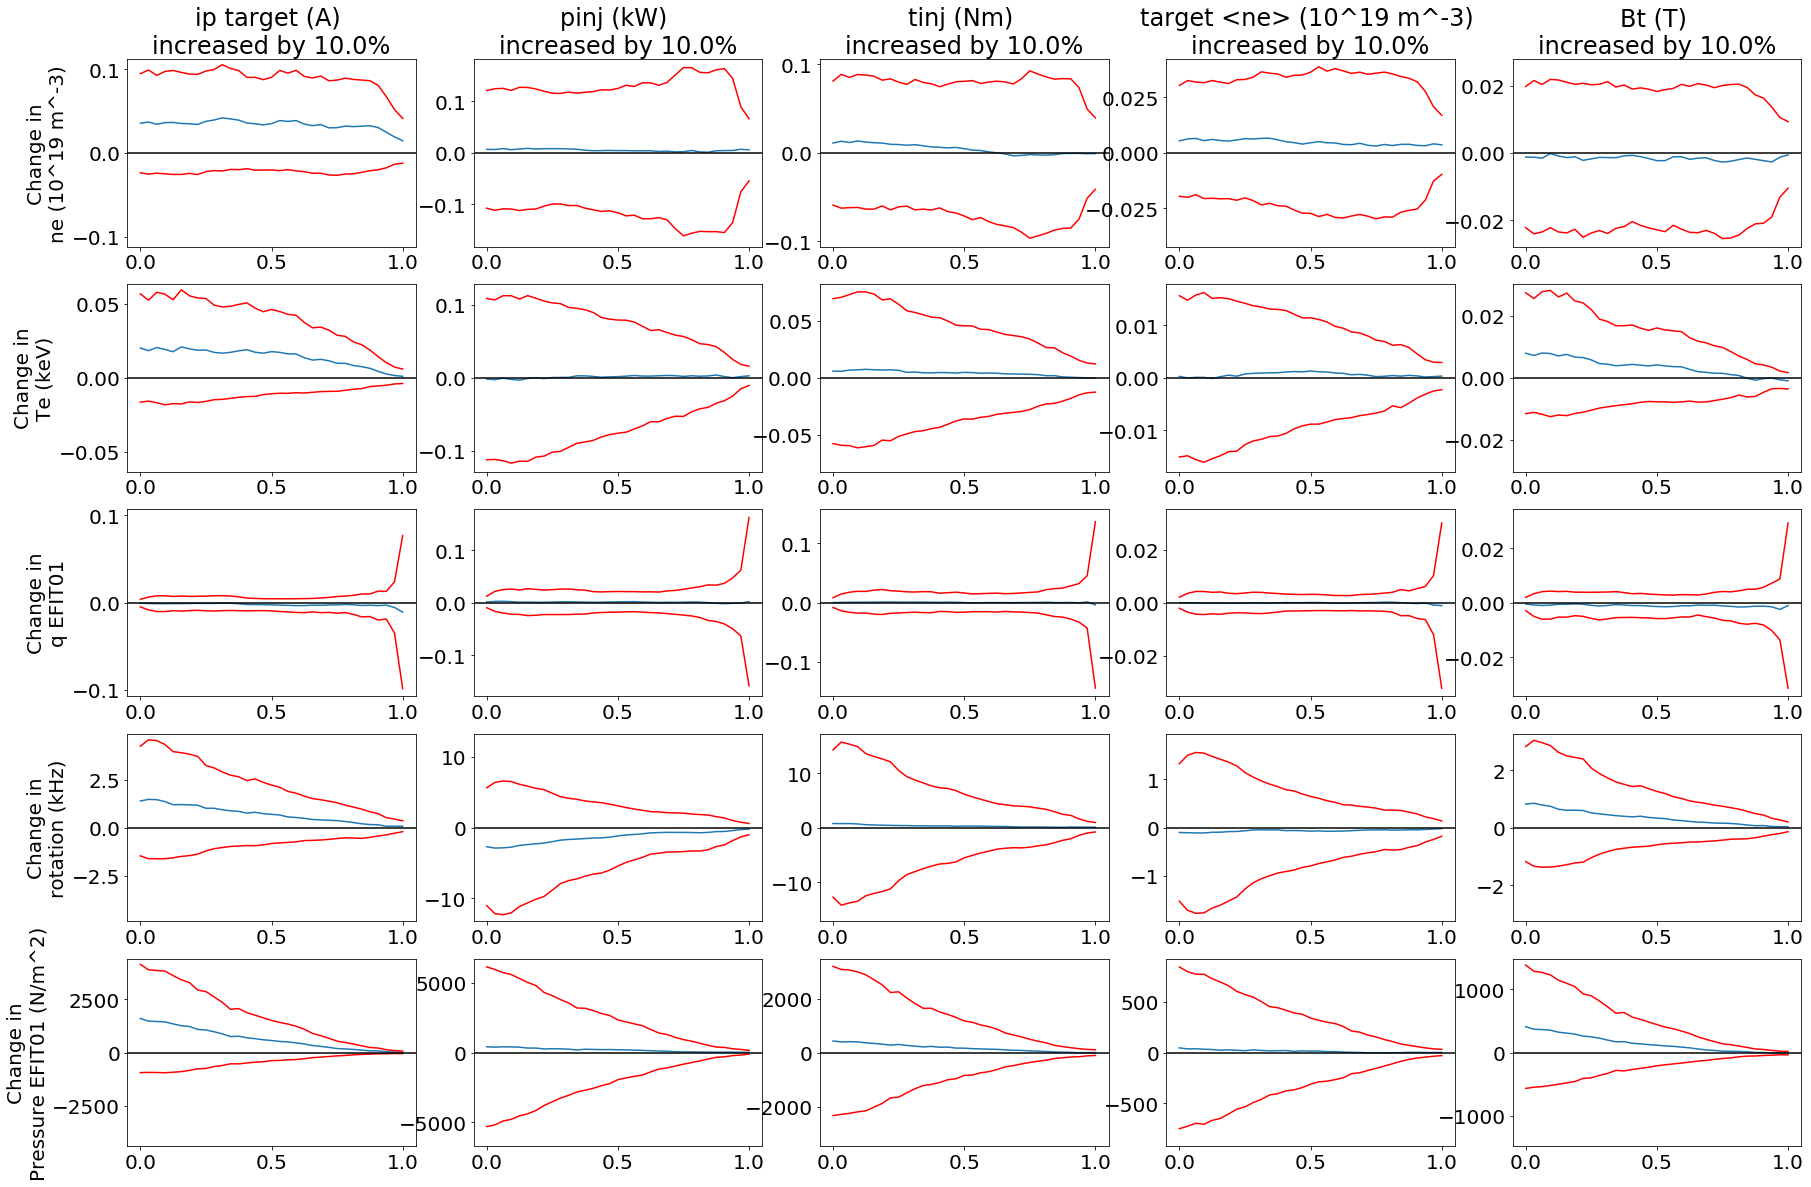

In [33]:
# if denormalized:
#     proper_traindata=denormed_traindata
# else:
#     proper_traindata=traindata
plt.rcParams["figure.figsize"] = (30,20)

import time
begin_time=time.time()

psi = np.linspace(0,1,scenario['profile_length'])
sigs=scenario['actuator_names']
profiles=scenario['target_profile_names']
input_profiles=scenario['input_profile_names']
changed_profile_keys=[] #'thomson_dens_EFITRT1']

sig_lims={'thomson_temp_EFITRT1': [0,2e3], 
          'rotation': [-.1,.1],
          'curr': [0,3e6],
          'temp':[-.05,.05],
          'q':[-.05,.05],
          'dens': [-.05,.05],
          'pinj': [0,1.5e4],
          'tinj':[0,10],
          'target_density': [0,8],
          'gasA': [0,10]}

average_change=np.zeros((len(sigs),len(profiles),len(psi)))
average_perturbation=np.zeros(len(sigs))
std_change=np.zeros((len(sigs),len(profiles),len(psi)))

denormalized=True
perturbation_size=.1

num_samples=len(train_generator)
for k in np.random.choice(len(train_generator),num_samples): #range(num_samples): 
    sample=train_generator[k]
    inputs=sample[0]
    targets=sample[1]
    predictions=model.predict_on_batch(inputs)
    
    for i,sig in enumerate(sigs):  
        changed_input=copy.deepcopy(inputs)
        #prev=changed_input['input_past_{}'.format(sig)][0][-1]
        # for fixed increase by perturbation size
        #changed_input['input_future_{}'.format(sig)][0]+=np.linspace(0,perturbation_size,scenario['lookahead'])
        
        # for percent increase
        prev=changed_input['input_past_{}'.format(sig)][0][-1]
        original_input_denormed=(prev*normalization_dict[sig]['iqr'])+normalization_dict[sig]['median']
        perturbed_input=original_input_denormed*(1+perturbation_size) #a perturbation size % increase
        
        average_perturbation[i]+=abs(original_input_denormed)*perturbation_size
        
        perturbed_input_final=(perturbed_input-normalization_dict[sig]['median'])/normalization_dict[sig]['iqr']
        changed_input['input_future_{}'.format(sig)][0]=np.linspace(prev,perturbed_input_final,scenario['lookahead'])
        
        changed_predictions=model.predict_on_batch(changed_input)

        for j,profile in enumerate(profiles):
            residual=changed_predictions[j][0]-predictions[j][0]
            average_change[i][j]+=(residual)
            std_change[i][j]+=np.square(residual)
                
# take the average 
average_change/=num_samples
std_change=np.sqrt(std_change/num_samples)
average_perturbation/=num_samples
                
fig=plt.figure()              
for i,sig in enumerate(sigs):  
    for j,profile in enumerate(profiles):
        ax=fig.add_subplot(len(profiles),len(sigs),j*len(sigs)+i+1)
        if j==0:
            ax.set_title('{} \nincreased by {}%'.format(sig_names[sig],
                                                     perturbation_size*100))
        if i==0:
            if profile in sig_names:
                ax.set_ylabel('Change in\n{}'.format(sig_names[profile]))
            else:
                ax.set_ylabel('Change in\n{}'.format(profile))
        
        if denormalized:
            average_change[i][j]*=normalization_dict[profile]['iqr']
            std_change[i][j]*=normalization_dict[profile]['iqr']
            
        ax.plot(psi,average_change[i][j])
        ax.plot(psi,average_change[i][j]+std_change[i][j],c='r')
        ax.plot(psi,average_change[i][j]-std_change[i][j],c='r')
        #ax.set_ylim(-.1,.1)
        ax.set_ylim(-max(np.abs(ax.get_ylim())),max(np.abs(ax.get_ylim())))
        ax.axhline(0,color='k')
        
print(time.time()-begin_time)
for i,sig in enumerate(sigs):
    print('{} average magnitude change: {}'.format(sig, average_perturbation[i]))

In [26]:
ax.get_xlim()

(-0.05, 1.05)

# Run the below cell to get PCA components #

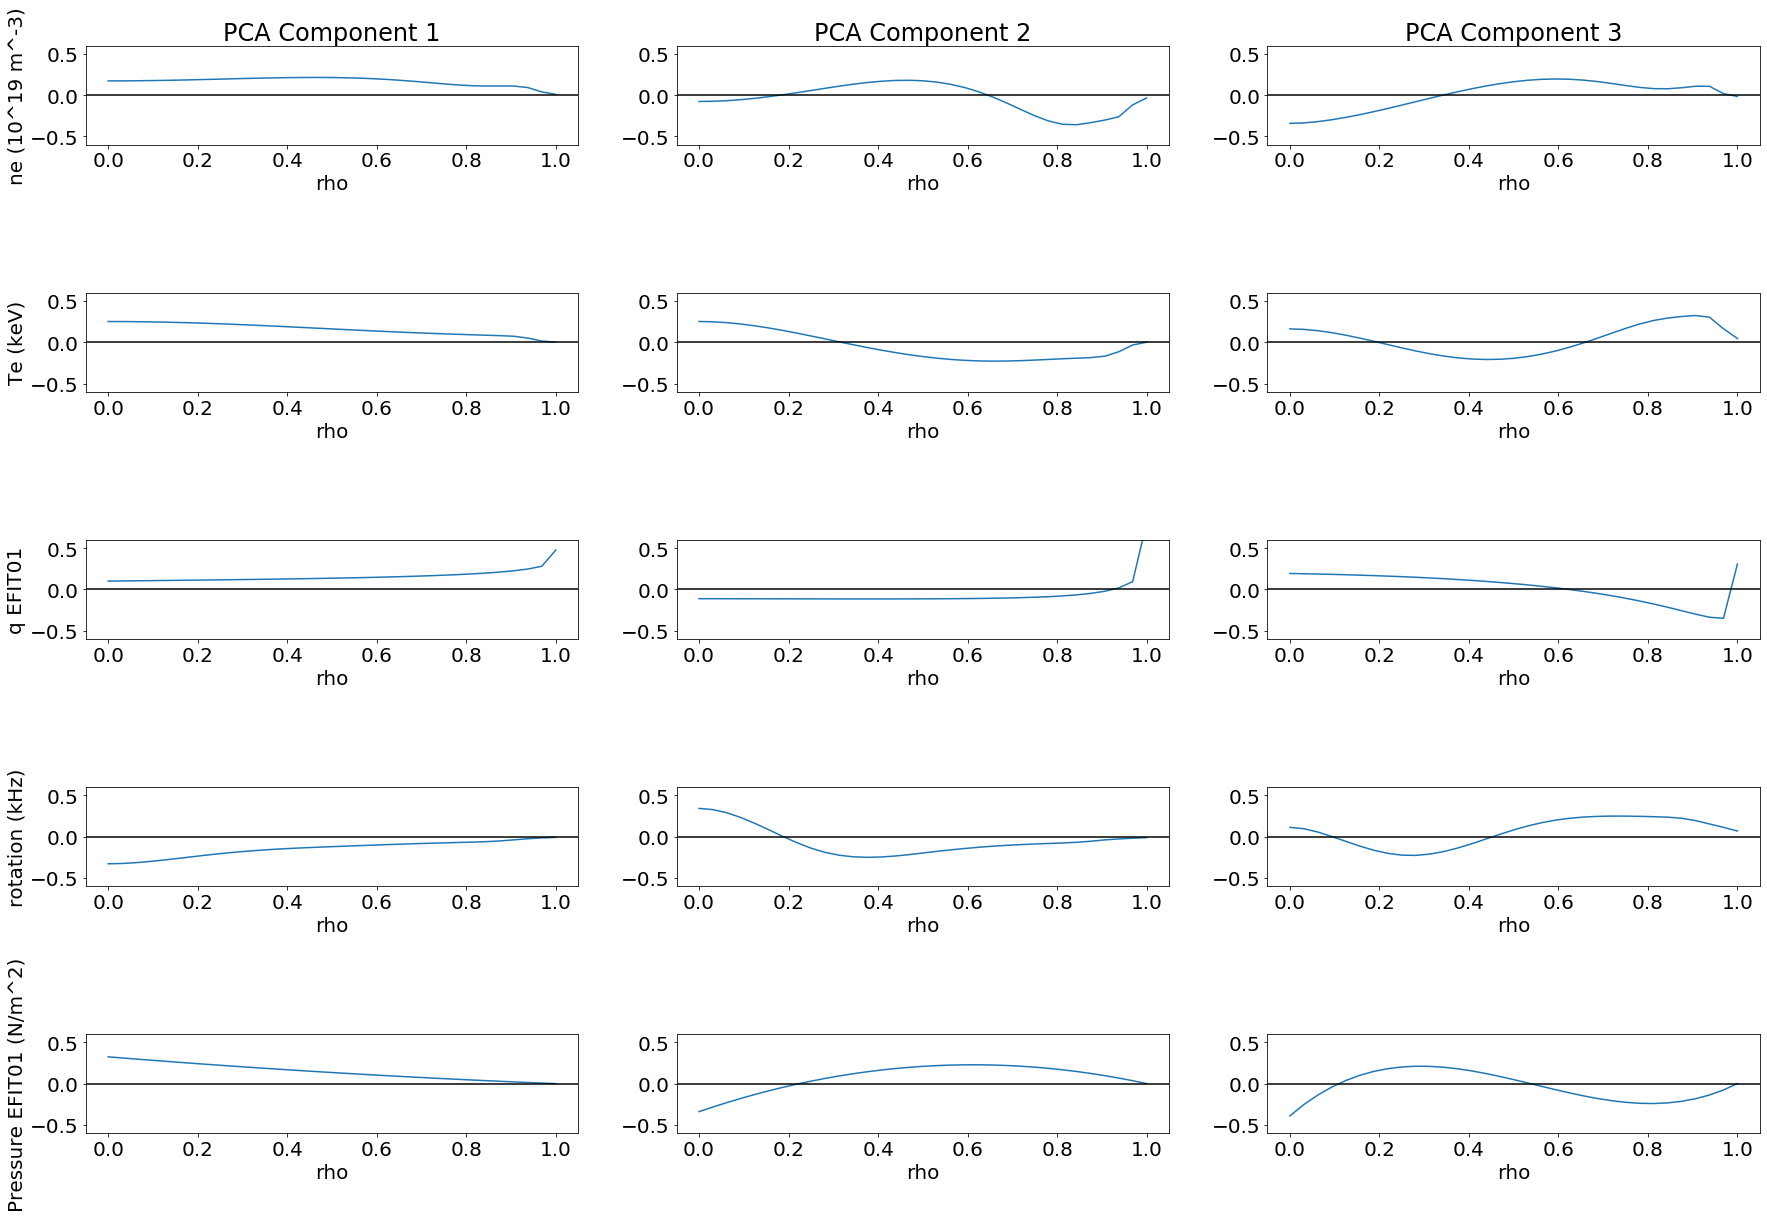

In [35]:
from sklearn import preprocessing
from sklearn import decomposition

profiles=scenario['target_profile_names']

pca_fitter={}

num_samples=1000
num_components=3


pre_pca={profile: [] for profile in profiles}

k=0
while k<num_samples:
    index=np.random.choice(len(train_generator))
    sample=train_generator[index]
    
    inputs=sample[0]
    targets=sample[1]
    
    for profile in profiles:
        this_input=inputs['input_{}'.format(profile)][0][0]
        pre_pca[profile].append(this_input)
        #target=targets['target_{}'.format(profile)][0]
        #pre_pca[profile].append(target)
        #pre_pca[profile].append(normalize(target,profile))
        
    k+=1
    
for profile in profiles:
    pca_fitter[profile]=decomposition.PCA(n_components=num_components).fit(pre_pca[profile])

fig=plt.figure()
for j,profile in enumerate(profiles):
    pca=pca_fitter[profile]
    for i in range(num_components):
        ax=fig.add_subplot(len(profiles),num_components,j*num_components+i+1)
        ax.plot(psi,pca.components_[i])
        if i==0:
            ax.set_ylabel(sig_names[profile])
        if j==0:
            ax.set_title('PCA Component {}'.format(i+1))
        ax.set_xlabel('rho')
        ax.set_ylim(-.6,.6)
        ax.axhline(0,c='k')
plt.xlabel('rho',fontsize=20)
plt.subplots_adjust(hspace=1.5)

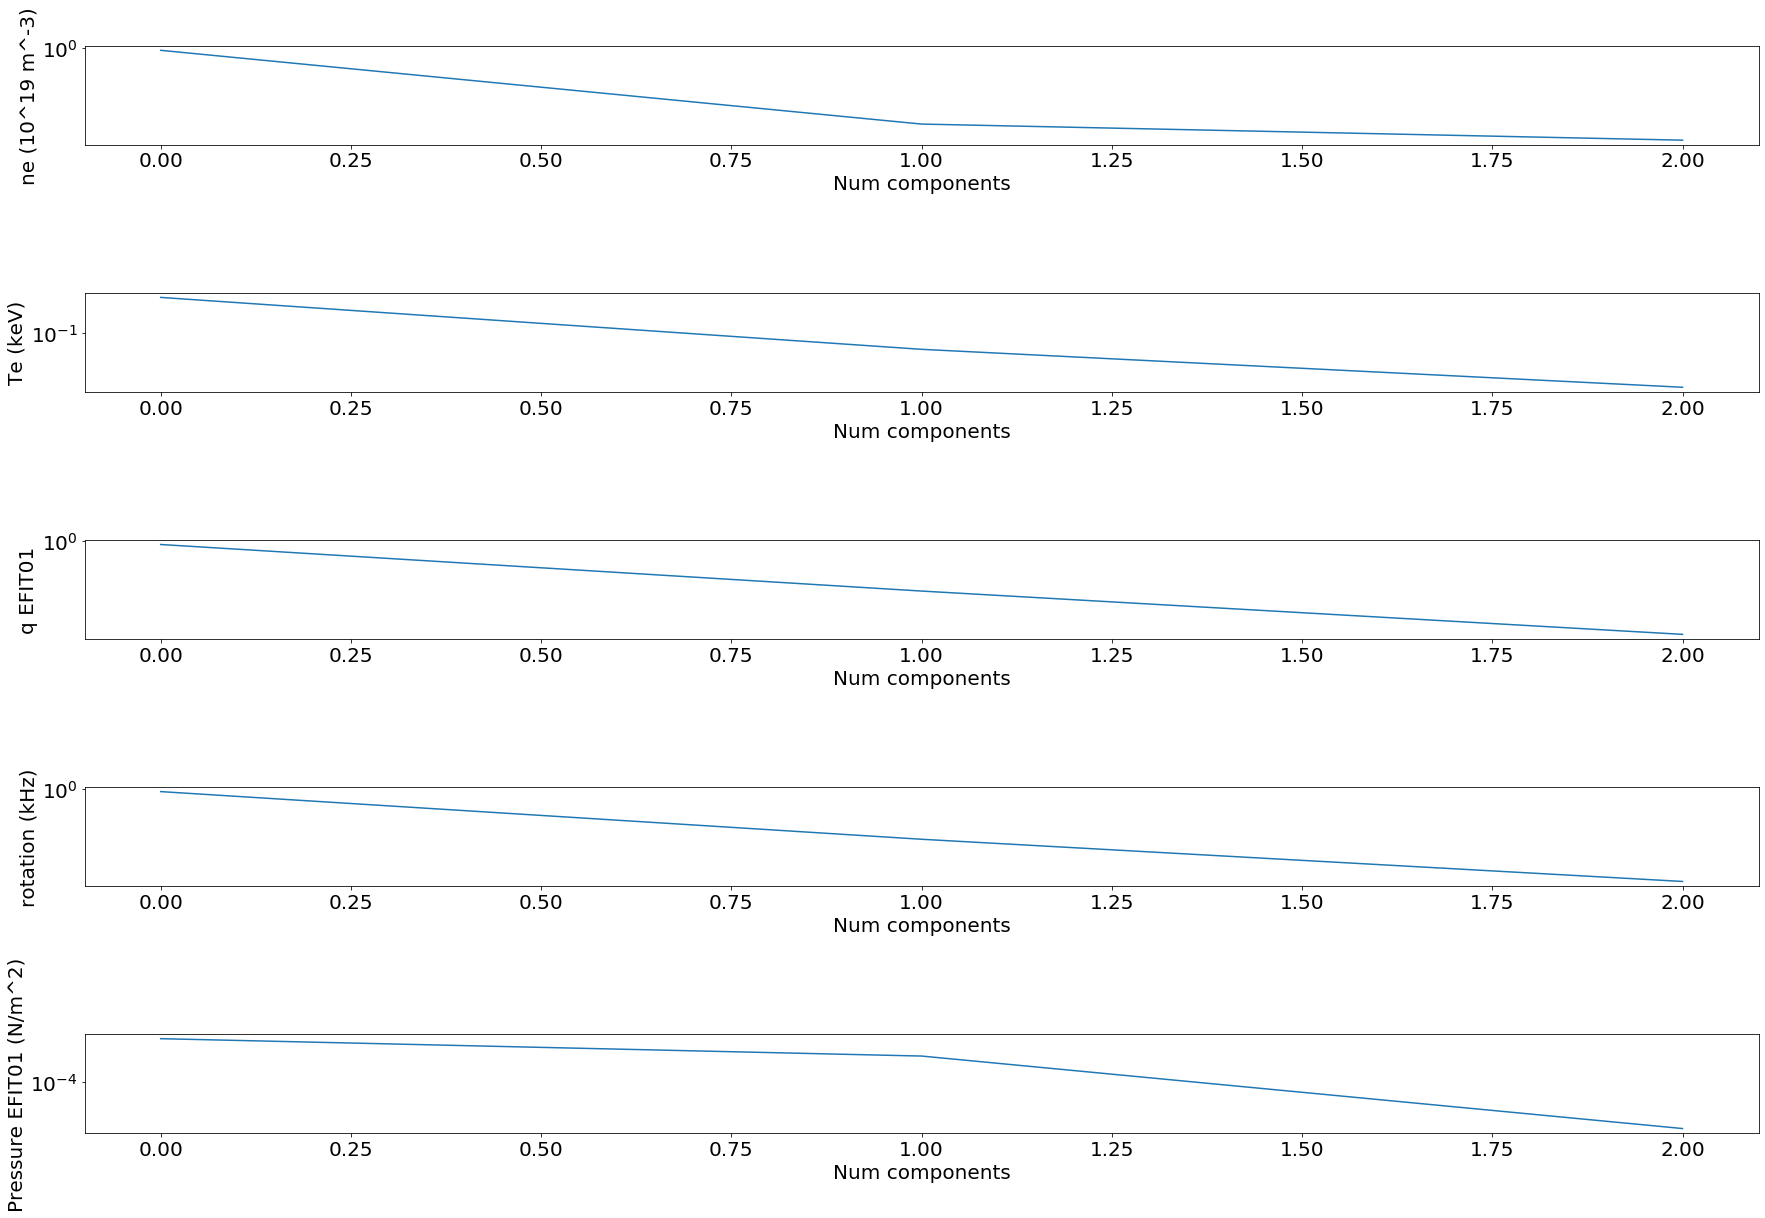

In [36]:
fig=plt.figure()
for j,profile in enumerate(profiles):
    pca=pca_fitter[profile]
    ax=fig.add_subplot(len(profiles),1,j+1)
    ax.plot([0,1,2],pca.explained_variance_ratio_)
    ax.set_ylabel(sig_names[profile])
    ax.set_xlabel('Num components')
    ax.set_yscale('log')
    ax.axhline(0,c='k')
plt.subplots_adjust(hspace=1.5)

# Average performance #

1.152500867843628


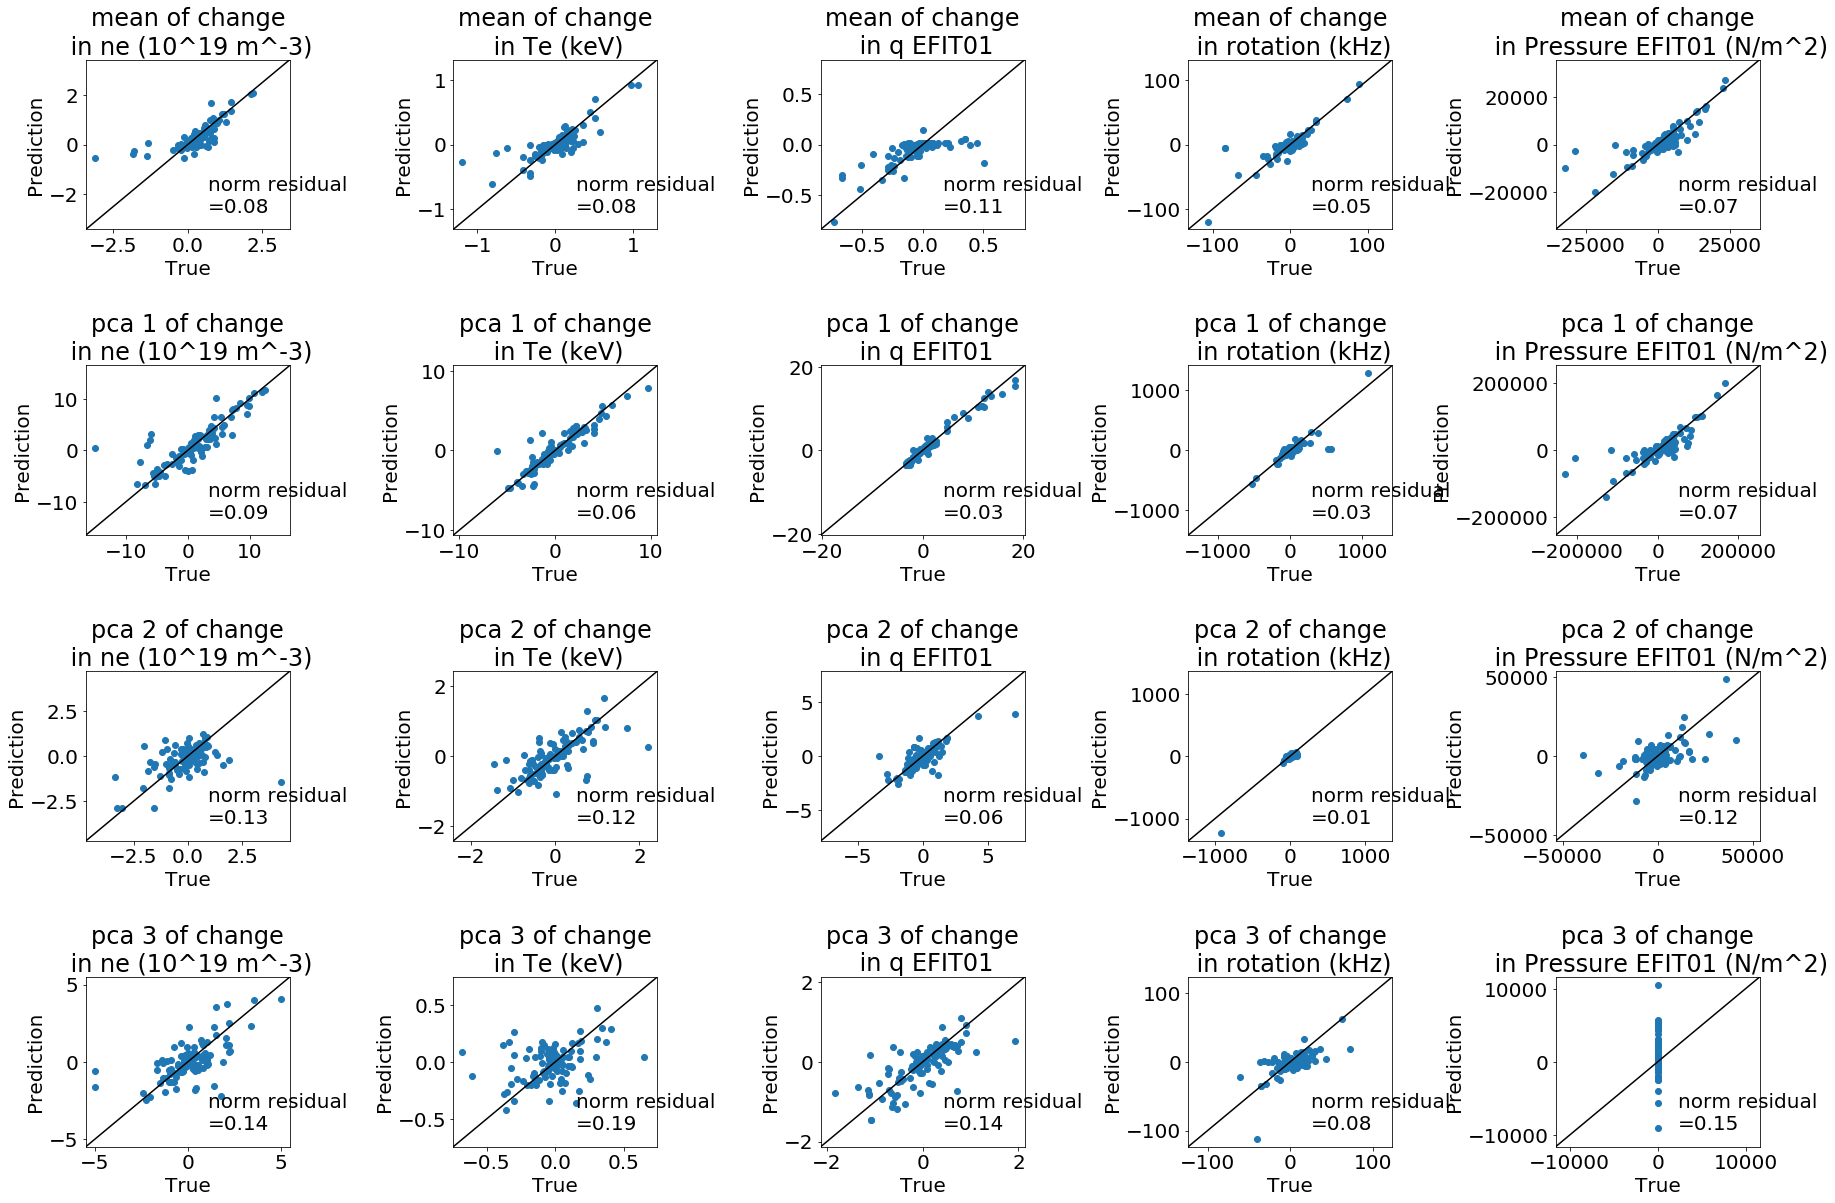

In [42]:
import time
begin_time=time.time()

plt.rcParams["figure.figsize"] = (30,20)

psi = np.linspace(0,1,scenario['profile_length'])
sigs=scenario['actuator_names']
profiles=scenario['target_profile_names']
input_profiles=scenario['input_profile_names']

sig_lims={'thomson_temp_EFITRT1': [0,2e3],    
          'rotation': {'mean': [-120,120], 'std': [0,100], 'pca 1': [-800,800], 'pca 2': [-250,250], 'pca 3': [-150,150]},
          'q_EFIT01': {'mean': [-1.5,1.5], 'std': [0,1], 'pca 1': [-12,12], 'pca 2': [-5,5], 'pca 3': [-5,5]},
          'press_EFIT01': {'mean': [-50000,50000], 'std': [0,50000], 'pca 1': [-300000,300000], 'pca 2': [-60000,60000], 'pca 3': [-50000,50000]},
          'temp': {'mean': [-1.8,1.8], 'std': [0,1], 'pca 1': [-15,15], 'pca 2': [-5,5], 'pca 3': [-5,5]}, 
          'dens': {'mean': [-2.5,2.5], 'std': [0,2], 'pca 1': [-20,20], 'pca 2': [-8,8], 'pca 3': [-8,8]},
          'pinj': [0,1.5e4],
          'tinj':[0,10],
          'target_density': [0,8],
          'gasA': [0,10]}

average_change=np.zeros((len(sigs),len(profiles),len(psi)))
std_change=np.zeros((len(sigs),len(profiles),len(psi)))

denormalized=True
perturbation_size=.1

num_samples=100 #len(train_generator)
    
def scalarize_mean(arr, **kwargs):
    return np.mean(arr)

def scalarize_std(arr, **kwargs):
    return np.std(arr)

def scalarize_pca_1(arr, **kwargs):
    # PCA of changes:
    #ret = pca_fitter[profile].transform([arr.squeeze()]).squeeze()[0]
    # raw PCA: 
    next_profile=kwargs['prev_profile'].squeeze()+arr.squeeze()
    ret = pca_fitter[profile].transform([next_profile]).squeeze()[0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    # PCA of changes:
    #ret = pca_fitter[profile].transform([arr.squeeze()]).squeeze()[1]
    # raw PCA: 
    next_profile=kwargs['prev_profile'].squeeze()+arr.squeeze()
    ret = pca_fitter[profile].transform([next_profile]).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    # PCA of changes:
    #ret = pca_fitter[profile].transform([arr.squeeze()]).squeeze()[2]
    # raw PCA: 
    next_profile=kwargs['prev_profile'].squeeze()+arr.squeeze()
    ret = pca_fitter[profile].transform([next_profile]).squeeze()[2]
    return ret

#for k in range(num_samples):
scalarize_functions=[scalarize_mean,scalarize_pca_1,scalarize_pca_2, scalarize_pca_3]
scalarize_function_names=['mean','pca 1','pca 2', 'pca 3']

true_profile=np.zeros((len(scalarize_functions),len(profiles),num_samples))
predicted_profile=np.zeros((len(scalarize_functions),len(profiles),num_samples))

k=0
while k<num_samples-1:
    
    index=np.random.choice(len(train_generator))
    #index=k
    sample=train_generator[index]
    inputs=sample[0]
    targets=sample[1]
    
    # only include if mean change in standardized profiles is greater than .1 for at least one profile
    skip=np.zeros(len(profiles))
    for j,profile in enumerate(profiles):
        target=targets['target_{}'.format(profile)][0]
        if abs(np.mean(target))<.1:
            skip[j]=1
    if all(skip):
        continue
    else:
        k+=1
    
    predictions=model.predict_on_batch(inputs)

    for j,profile in enumerate(profiles):
        target=targets['target_{}'.format(profile)][0]
        if denormalized:
            #predicted_profile[i][j][k]=normalize(predicted_profile[i][j][k],profile) 
            #true_profile[i][j][k]=normalize(true_profile[i][j][k],profile)
            predictions[j]=normalize(predictions[j],profile) 
            target=normalize(target,profile)
        for i,scalarize in enumerate(scalarize_functions):
            #true_profile[i][j][k]=scalarize(target,profile)
            #predicted_profile[i][j][k]=scalarize(predictions[j],profile)
            true_profile[i][j][k]=scalarize(target,profile=profile, prev_profile=inputs['input_{}'.format(profile)])
            predicted_profile[i][j][k]=scalarize(predictions[j],profile=profile, prev_profile=inputs['input_{}'.format(profile)])
                
fig=plt.figure()    
for i,profile in enumerate(profiles):
    for j,scalarize_name in enumerate(scalarize_function_names):
        pred=predicted_profile[j][i]
        true=true_profile[j][i]
        
        ax=fig.add_subplot(len(scalarize_functions),len(profiles),j*len(profiles)+i+1)
        ax.set_title('{} of change\n in {}'.format(scalarize_name,sig_names[profile]))
        
        # 1-1 plot:
        ax.scatter(true_profile[j][i],predicted_profile[j][i])
        
        # residual plot:
        #ax.scatter(true_profile[j][i],predicted_profile[j][i]-true_profile[j][i])
        #ax.axhline(0,color='k')
        
        # for custom bounds:
        #ax.set_ylim(sig_lims[profile][scalarize_name])
        #ax.set_xlim(sig_lims[profile][scalarize_name])
        
        # for residual
        #max_yval=1.1*max(np.abs(predicted_profile[j][i]-true_profile[j][i]))
        # for raw
        max_yval=1.1*max(np.abs(pred))
        max_xval=1.1*max(np.abs(true))
        max_val=max(max_xval,max_yval)
        
        ax.set_xlim(-max_val,max_val)
        ax.set_ylim(-max_val,max_val)
        
        # for raw
        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k')
        ax.set_xlabel('True')
        ax.set_ylabel('Prediction')
        
        #avg_residual=np.mean(np.abs(pred-true))
        #normalized_residual=avg_residual/max_val
        
        #ax.text(.6,.1,'norm residual\n={0:0.2f}'.format(normalized_residual),transform = ax.transAxes)

plt.subplots_adjust(hspace=.8, wspace=.8)
print(time.time()-begin_time)

In [43]:
pred=predicted_profile[0][1]
true=true_profile[0][1]

ss_res=np.sum(pow(pred-true,2))
ss_tot=np.sum(pow(true-np.mean(true),2))
print(ss_tot)
print(ss_res)
print(1-ss_res/ss_tot)

8.518300100645245
2.886338276483064
0.6611602969629552


# Make the colorbar plots

In [198]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['font.size'] = 50

import numpy as np
import matplotlib.pyplot as plt

shots=list(data.keys())
shot=170701 #np.random.choice(shots)
sigs=['curr','temp','pinj','tinj','dens','gasA','ech'] #['ffprime_EFITRT1','curr_target','pinj','temp','dens','gas_feedback','target_density','gasA','gasA_voltage', 'beam_feedback_switch', 'beam_feedback_power_target_quantity', 'realtime_betan']
sig_names={'curr': 'Current\n(MA)',
           'temp':'Electron Temperature\n(keV)', 
           'dens': 'Electron Density\n(10^19 cm^-3)',
           'itemp':'Ion Temperature\n(keV)', 
           'pinj': 'NB Power\n(MW)', 
           'gasA': 'Gas\n(V)',
           'ech': 'ECH Power\n(MW)',
           'tinj': 'NB Torque\n(Rad/s)'}
conversion_factor={'temp': 1000,
                  'dens':1e19,
                  'pinj': 1000,
                  'tinj': 1,
                  'curr': 1e6,
                  'gasA': 1,
                  'ech': 1}

#sigs=['curr_target','pinj','temp','dens','target_source_pinj_30L','beam_feedback_switch','beam_feedback_switch','beam_feedback_power_target_quantity','beam_feedback_power_target_value','realtime_betan']
assert(all(data[shot]['gas_density_or_profile_algorithm']==0))

def removeOutliers(x, outlierConstant, sig):
    #upper_quartile = np.nanpercentile(x, 75)
    #lower_quartile = np.nanpercentile(x, 25)
    upper_quartile=quartiles[sig]['upper']
    lower_quartile=quartiles[sig]['lower']
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    return np.clip(x,lower_quartile - IQR,upper_quartile + IQR)


def my_normalize(arr):
    return (arr-np.nanmin(arr))/(np.nanmax(arr)-np.nanmin(arr))

fig=plt.figure()
for i,sig in enumerate(sigs):
    ax=fig.add_subplot(len(sigs),1.5,i+1)
    ax.axvline(data[shot]['t_ip_flat'],c='r')
    ax.axvline(data[shot]['t_ip_flat']+data[shot]['ip_flat_duration'],c='r')
    if sig in ['temp','dens']: #len(data[shot][sig].shape)>1:
        #thomson_sig_name='thomson_{}_EFITRT1'.format(sig)
        #thomson_sig=data[shot][thomson_sig_name]
        #thomson_sig=removeOutliers(thomson_sig,1.5,thomson_sig_name)
        #ax.plot(data[shot]['time'],my_normalize(data[shot]['pinj']),c='r')
            
        zipfit_sig=np.mean(data[shot][sig],axis=1) #my_normalize(np.mean(data[shot][sig],axis=1))
        
        ax.contourf(data[shot]['time'],
            np.linspace(0,np.nanmax(data[shot][sig]),65),
            #thomson_sig.T)
            data[shot][sig].T)
        
        ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
        ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3,label='Fitted')
        
        #thomson_sig=np.mean(thomson_sig,axis=1)/conversion_factor[sig] #my_normalize(np.mean(thomson_sig,axis=1))
        #ax.plot(data[shot]['time'],thomson_sig,c='b',linewidth=7,label='Raw Thomson')
        #ax.legend()
        #ax.plot(data[shot]['time'],my_normalize(np.mean(data[shot]['thomson_{}_EFITRT1'.format(sig)],axis=1), clip=True, sig=sig),c='g',linewidth=3)
    elif len(data[shot][sig].shape)>1:
        thomson_sig=removeOutliers(data[shot][sig],1.5,sig)
        
        ax.contourf(data[shot]['time'],
                    np.linspace(0,1,65),
                    #thomson_sig.T)
                    data[shot][sig].T)
            
#         zipfit_sig=my_normalize(np.mean(data[shot][sig],axis=1))
#         ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
#         ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3)
        
       
    elif sig=='target_density':
        ax.plot(data[shot]['time'],data[shot]['density_estimate'])
        ax.plot(data[shot]['time'],data[shot]['target_density'],c='r')
    elif sig=='realtime_betan':
        ax.plot(data[shot]['time'],data[shot]['realtime_betan'])
        ax.plot(data[shot]['time'],data[shot]['beam_feedback_power_target_value'],c='r')
    elif sig=='curr_target':
        ax.plot(data[shot]['time'],data[shot]['curr'])
        ax.plot(data[shot]['time'],data[shot]['curr_target'],c='r')
        
    else:
        ax.plot(data[shot]['time'],data[shot][sig]/conversion_factor[sig])
    ax.set_ylabel(sig_names[sig])
    ax.set_xlim(min(data[shot]['time']),max(data[shot]['time']))
    #ax.axvline(2220)
    #ax.axvline(2270)
plt.xlabel('Time (ms)')
#plt.subplots_adjust(hspace=.5)
fig.suptitle('Shot {}'.format(shot),fontsize=30)
plt.show()

NameError: name 'data' is not defined